[GitHub.io Link](marklisi1.github.io)

# Milestone 1
<p> Mark Lisi<br>
Sarper Tutuncuoglu </p>

Our group plans to investigate patterns in job applications and hiring in the city of New Orleans. We plan to focus predominantly on New Orleans City Service Departments in our analysis. 
	

The first dataset we have found describes [hiring data for city jobs in New Orleans.](https://data.nola.gov/City-Administration/City-Jobs-Hiring-Data/wx2k-rsac/data) We took this dataset from data.nola.gov. The dataset contains information about the job title/department, as well as the term length of the hire. One of the trends that we hope to further explore is a relationship between hire length and type of job. We believe that probationary hires may be unfairly exploited based on the easily terminable nature of their hiring terms. 
	

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string

In [12]:
hiring_df = pd.read_csv("./data/City_Jobs_Hiring_Data.csv")
hiring_df.head()

,Start_Date,Job_Title,Department,Department_Code,Job_Term,List_Type,Req_Number,Appointment_Type
0,01/13/2020 06:00:00 AM,"OFFICE ASSISTANT, TRAINEE (CLASS CODE 0020)",Office Of Community Development,719,Probationary,Regular and Promotional,2019-02185,New Hire/Rehire
1,02/23/2020 12:00:00 AM,"OFFICE ASSISTANT, TRAINEE (CLASS CODE 0020)",Property Management,450,Probationary,Regular and Promotional,2020-00541,New Hire/Rehire
2,01/19/2020 12:00:00 AM,POLICE AIDE (CLASS CODE 7105),Police Department,270,Probationary,Regular,2020-00088,New Hire/Rehire
3,03/01/2020 12:00:00 AM,POLICE AIDE (CLASS CODE 7105),Police Department,270,Provisional,Regular,2020-00628,New Hire/Rehire
4,03/15/2020 12:00:00 AM,POLICE AIDE (CLASS CODE 7105),Police Department,270,Provisional,Regular,2020-00645,New Hire/Rehire


Luckily, most of the data on data.nola.gov is already tidy. We can also observe that our only numerical variable, Start_Date, has a value in every entry. 

In [13]:
hiring_df[hiring_df["Start_Date"].isnull()]

,Start_Date,Job_Title,Department,Department_Code,Job_Term,List_Type,Req_Number,Appointment_Type


Because of this, we do not need to worry about NaNs. However, this dataset does have a few limitations. Firstly, it is not very large - if we hope to draw any widely applicable conclusions, we will need to find a bigger source of data. However, we believe that the trends which emerge in this dataset will help point us in the right direction for the rest of our project. Additionally, it lacks some demographic statistics that might generate more powerful conclusions - the pay of each job, the race and gender of the applicant, etc. We hope to gain insight on these topics by crossreferencing this dataset with others - potentially IRS/FRED data.
	

Another dataset we are considering working with is [city job applications.](https://data.nola.gov/City-Administration/City-Job-Applications-Submitted/ewwx-j8eu/data)

In [14]:
application_df = pd.read_csv("./data/City_Job_Applications_Submitted.csv")
application_df.head()

,City Job Title,Application Date
0,311 TELECOMMUNICATIONS OPERATOR (CLASS CODE 7401),02/16/2018 12:00:00 AM
1,311 TELECOMMUNICATIONS OPERATOR (CLASS CODE 7401),02/16/2018 12:00:00 AM
2,311 TELECOMMUNICATIONS OPERATOR (CLASS CODE 7401),02/16/2018 12:00:00 AM
3,311 TELECOMMUNICATIONS OPERATOR (CLASS CODE 7401),02/16/2018 12:00:00 AM
4,311 TELECOMMUNICATIONS OPERATOR (CLASS CODE 7401),02/16/2018 12:00:00 AM


 This dataset doesn’t give us much - simply the title of the job applied for and the time of application - but it is considerably larger than the first dataset. We can at least determine which jobs are most frequently applied to at different times of year using this dataset.
	

For our collaboration plan, we are primarily using a combination of Github and Zoom meetings. We both have experience using Github to coordinate code in group projects, so we should be able to maintain an organized work environment. We have been meeting over Zoom on Sundays to touch base about work scheduling, but we are both able to have relatively flexible meeting patterns as the semester progresses.

We can also take a look at the city job requisition requests.

In [15]:
req_df = pd.read_csv("./data/City_Jobs_Requisition_Requests.csv")
req_df.head()

,Req_Title,Req_Status,Department,Department_Code,Division,Job_Term,Received_Date,Req_Number,Description_Of_Duties_This_Sh
0,"Executive Counsel, City Council",Approved,City Council,200,Office of Chief of Staff,Unclassified,01/18/2019 11:38:37 AM,2019-00013,Representing the City Council's interests in l...
1,OFFICE ASSISTANT I (PROMOTIONAL) (CLASS CODE 0...,Filled,City Council,200,Council Research,Probationary,02/04/2019 10:53:57 AM,2019-00529,Promotion of Mary Hammothe from Office Assista...
2,Community Relations & Constituent Services Rep.,Approved,City Council,200,Council District D,Unclassified,02/13/2019 10:44:16 AM,2019-00570,The Community Relations & Constituent Services...
3,Constituent Services and Outreach,Approved,City Council,200,Council District B,Unclassified,02/20/2019 12:29:38 PM,2019-00673,Ms. Brock will be responsible for supporting t...
4,Legislative Aide,Approved,City Council,200,Council District A,Unclassified,03/04/2019 02:56:05 PM,2019-00745,Legislative Aide working part-time in Council ...


The `Req_Status` variable gives us a good preliminary impression of the demand for city jobs - how often city jobs requests are requested, versus how often they are fulfilled. 

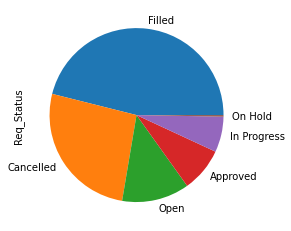

In [16]:
req_df['Req_Status'].value_counts().plot.pie()

We can map these values numerically to determine which city jobs are most or least likely to be filled. We can consider the values "Filled" or "Approved" as a full completion of the request (1), and "On Hold", "Open" or "Cancelled" as an incomplete request (0). We can map "In Progress" as a partial completion (0.5). We can then take the mean to determine the approximate probability that a request will be fulfilled. 

In [17]:
req_df["Req_Status_Num"] = req_df["Req_Status"].map({
       "Filled": 1,
       "Approved": 1,
       "In Progress": 0.5,
       "Cancelled": 0,
       "Open": 0,
       "On Hold": 0
})

req_df["Req_Status_Num"].mean()

0.576

The overall probability that a request will be fulfilled is ~57.6%. Now, we can inspect these probabilities by department.

In [18]:
req_df.groupby(['Department'])["Req_Status_Num"].mean().sort_values(ascending=False)

Department
Municipal Yacht Harbor                            1.000000
Coroner's Office                                  1.000000
Historic Districts and Landmarks Commission       1.000000
New Orleans Public Library                        1.000000
Law Department                                    0.961538
Juvenile Court                                    0.916667
Sanitation Department                             0.858824
Mayor's Office                                    0.855140
Vieux Carre Commission                            0.833333
Office Of Community Development                   0.833333
Parks & Parkways                                  0.802469
Clerk of Criminal District Court                  0.800000
City Council                                      0.791667
Municipal Court                                   0.784314
Civil Service Department                          0.767857
Health Department                                 0.699367
Fire Department                              

## New Orleans City Jobs Pay Plan


<p> The following code is to scrape the data in this PDF document which was retreived through the New Orleans city website. <a href="./data/nola_city_jobs_pay_plan.pdf"> New Orleans City Jobs Pay Plan</a> </p>

<p> The PDF was first converted into a text file using this tool: <a href="https://www.pdf2go.com/pdf-to-text"> PDF Converter</a></p>

In [19]:
f = open('./data/nola_city_jobs_pay_plan_edited_pay_grade_table.txt', 'r') 
raw_str = f.read()
f.close

raw_str = raw_str.replace('\n\n', '\n') #remove empty lines

raw_str = raw_str.replace(' ', '') #some numbers have spaces in between them, remove those spaces
raw_str = raw_str.replace('.', '') #remove all the decimal point dots to make all numbers consistent (all numbers in the PDF have 2 decimal points, so it can be fixed later)

raw_numbers = raw_str.split('\n') #every line as an element in a list

raw_numbers = [element for element in raw_numbers if element.isnumeric()] #remove titles/headers

data = {}
    
first_page_length = 85 - 34 + 1    
second_page_length = 135 - 86 + 1

for i, entry in enumerate(raw_numbers):
    
    if i < first_page_length: data.setdefault('Pay Grade', []).append(int(entry))
    elif i < 2*first_page_length: data.setdefault('Step 1', []).append(entry)
    elif i < 3*first_page_length: data.setdefault('Step 2', []).append(entry)
    elif i < 4*first_page_length: data.setdefault('Step 3', []).append(entry)
    elif i < 5*first_page_length: data.setdefault('Step 4', []).append(entry)
    elif i < 6*first_page_length: data.setdefault('Step 5', []).append(entry)
    elif i < 7*first_page_length: data.setdefault('Step 11', []).append(entry)
    elif i < 8*first_page_length: data.setdefault('Step 21', []).append(entry)
    elif i < 9*first_page_length: data.setdefault('Step 41', []).append(entry)
    elif i < 9*first_page_length + second_page_length: data['Pay Grade'].append(int(entry))
    elif i < 9*first_page_length + 2*second_page_length: data['Step 1'].append(entry)
    elif i < 9*first_page_length + 3*second_page_length: data['Step 2'].append(entry)
    elif i < 9*first_page_length + 4*second_page_length: data['Step 3'].append(entry)
    elif i < 9*first_page_length + 5*second_page_length: data['Step 4'].append(entry)
    elif i < 9*first_page_length + 6*second_page_length: data['Step 5'].append(entry)
    elif i < 9*first_page_length + 7*second_page_length: data['Step 11'].append(entry)
    elif i < 9*first_page_length + 8*second_page_length: data['Step 21'].append(entry)
    elif i < 9*first_page_length + 9*second_page_length: data['Step 41'].append(entry)
    
length = 135 - 34 + 1

for key in data:
    if(len(data[key]) != length):
        print("LENGTHS DON'T MATCH")
        
#LENGTHS MATCH!

#add decimal points to pay data and convert to float
data = {key: [float(elem[:-2] + '.' + elem[-2:]) for elem in data[key]] if key != 'Pay Grade' else data[key] for key in data}

In [20]:
pay_grades_df = pd.DataFrame(data)
pay_grades_df.head()

,Pay Grade,Step 1,Step 2,Step 3,Step 4,Step 5,Step 11,Step 21,Step 41
0,34,15909.85,16108.73,16310.09,16513.96,16720.39,18014.26,20397.03,26149.75
1,35,16310.09,16513.96,16720.39,16929.39,17141.01,18467.44,20910.14,26807.58
2,36,16720.39,16929.39,17141.01,17355.27,17572.21,18932.01,21436.16,27481.95
3,37,17141.01,17355.27,17572.21,17791.87,18014.26,19408.26,21975.41,28173.30
4,38,17572.21,17791.87,18014.26,18239.44,18467.44,19896.50,22528.23,28882.03


This data shows the: 
<ul>
    <li>minimum (Step 1)</li>
    <li>2nd quartile (Step 11)</li>
    <li>midpoint (Step 21)</li>
    <li>maximum (Step 41)</li>
</ul>

salaries for the corresponding pay grades

This <a href="https://www.utdallas.edu/hr/compensation/standards/#:~:text=Second%20Quartile%3A%20The%20second%20quartile,experienced%20employee%20at%20that%20level."> UT Dallas </a> source helps us understand how salary quartiles work:

<img src="./src/salary_ranges_and_quartiles.png"/>

The following code is to scrape the rows that map city positions to min and max pay ranges in the <a href="./data/nola_city_jobs_pay_plan.pdf">PDF</a>

In [102]:
f = open('./data/nola_city_jobs_pay_plan_edited_positions_to_pay.txt', 'r') 
raw_str = f.read()
f.close

raw_str = raw_str.replace('\x0c', '') #remove the weirdly encoded characters
raw_str = raw_str.replace('\n\n', '\n') #remove empty rows

#characters to filter in
characters = list(string.ascii_uppercase) + list(string.ascii_lowercase) + list(string.digits) + [' ', ',', '(', ')', '\n']

#filter out all the characters that are not in the 'characters' list
raw_str = ''.join([character for character in raw_str if character in characters])

rows = raw_str.split('\n')
rows

data = []

for row in rows:
    line = row.strip()

    cleaned_row  = []
    elements = line.split(' ')
    elements = [element for element in elements if element != '']
    #print(elements)
    
    if len(elements) < 5: continue
    
    
    
    
    elem = elements.pop(0)

    if elem == 'EX':
        cleaned_row.append('EX')
        elem = elements.pop(0)
    else:
        cleaned_row.append(np.nan)

    if elem[0] == '(':
        cleaned_row.append(elem[1])
        elem = elements.pop(0)
    else:
        cleaned_row.append(np.nan)

    if elem[0] == 'C' or (len(elem) > 1 and elem[1].isnumeric()):
        cleaned_row.append(elem)
    else:
        cleaned_row.append(np.nan)

        
    if cleaned_row == [np.nan, np.nan, np.nan]: continue
    
    
    
    position = ''
    
    elem = elements.pop(0)
    while (not elem.isnumeric() or elem == '311' or elem == '911') and not elem =='Y':
        position += elem + ' '
        elem = elements.pop(0)
    
    cleaned_row.append(position.strip())
    
    if elem == 'Y':
        cleaned_row.append(True)
    elif elem.isnumeric():
        cleaned_row.append(False)
        cleaned_row.append(elem)
    
    cleaned_row += elements
        
    data.append(cleaned_row)
        
data = [row for row in data if len(row) == 10]

for row in data:
    
    row[6] = row[6].replace('(', '')
    row[6] = row[6].replace(')', '')
    row[9] = row[9].replace('(', '')
    row[9] = row[9].replace(')', '')
    
    row[6] = float(row[6].replace(',', ''))
    row[7] = float(row[7].replace(',', ''))
    try:
        row[9] = float(row[9].replace(',', ''))
    except ValueError:
        row[9] = np.nan


In [103]:
positions_to_pay_df = pd.DataFrame(data, columns=[
    'EAP', 'OC', 'Code', 'Position Class', 'EQP', 'Grade', 'Min', 'Max', 'Step', 'Rate'
])
positions_to_pay_df.head()

,EAP,OC,Code,Position Class,EQP,Grade,Min,Max,Step,Rate
0,NaN,NaN,C7401,311 TELECOMMUNICATIONS OPERATOR,False,50,23675.0,38914.0,09,26149.0
1,NaN,NaN,C7406,"311 TELECOMMUNICATIONS OPERATOR, DIVISION MANAGER",False,1,39893.0,65569.0,09,44061.0
2,NaN,NaN,C7405,"311 TELECOMMUNICATIONS OPERATOR, PRINCIPAL",False,61,31117.0,51144.0,09,34368.0
3,NaN,NaN,C7402,"311 TELECOMMUNICATIONS OPERATOR, SENIOR",False,56,27481.0,45169.0,09,30353.0
4,NaN,NaN,C7403,"311 TELECOMMUNICATIONS OPERATOR, SUPERVISOR",False,67,36119.0,59366.0,09,39893.0


<ul>
    <li><strong>EAP</strong>: "EX" to indicate which classifications are exempt from the FLSA regulations on overtime</li>
    <li><strong>OC</strong>:  Occupational code as defined by the Federal Equal Employment Opportunity Commission</li>
    <li><strong>Code</strong>: Code for position class</li>
    <li><strong>Position Class</strong>: Description of job title</li>
    <li><strong>EQP</strong>:  Indicates positions where employees have been hired at a rate above the base rate</li>
    <li><strong>Grade</strong>: Pay grade (the corresponding pay grade in the <strong>pay_grades_df</strong> table)</li>
    <li><strong>Min</strong>: Minimum salary for position</li>
    <li><strong>Max</strong>: Maximum salary for position</li>
    <li><strong>Step</strong>: Pay grade step (the corresponding step in the <strong>pay_grades_df</strong> table)</li>
    <li><strong>Rate</strong>: Hiring rate (salary to which an employee is assigned upon entering the job)</li>
</ul>

In [104]:
positions_to_pay_df.dtypes

EAP                object
OC                 object
Code               object
Position Class     object
EQP                  bool
Grade              object
Min               float64
Max               float64
Step               object
Rate              float64
dtype: object

The histogram below shows the distribution of the hiring rates of city jobs. Hiring rate is the rate at which an employee is first hired for the position). We can see that it's highly skewed to the right, which is expected.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f634f010c40>]],
      dtype=object)

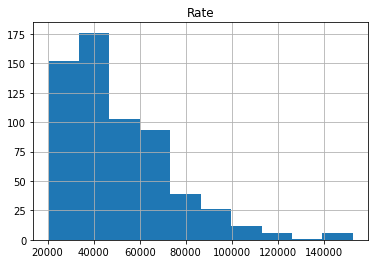

In [105]:
positions_to_pay_df.hist('Rate', bins=10)

In [106]:
positions_to_pay_df[['Min', 'Max', 'Rate']].describe()

,Min,Max,Rate
count,662.000000,662.000000,614.000000
mean,45118.051360,72989.531722,51238.956026
std,20613.189732,32578.382683,22865.071056
min,3232.000000,7675.000000,20397.000000
25%,30353.000000,49889.000000,34368.000000
50%,39893.000000,65569.000000,45169.000000
75%,55102.000000,90567.000000,63960.000000
max,128242.000000,210781.000000,152602.000000
